# Data Playground
#### M Chu
Collection of ideas; serves as a running, semi-organized progress report.

Will consolidate, reorganize & streamline the codes once we find out what works and what doesn't / decide on which direction we will be focusing on.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import timeit

#%matplotlib inline
import matplotlib.pyplot as plt

## Importing data

More rows than columns; not good. Collecting a more tick data of the same stocks is trivial, but for now we'll work with this dataset.

In [2]:
raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')
log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
# drop first row of raw prices so it has the same dimensions as the log-returns DF
raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
stock_names = log_returns_df.columns

df_shape = (raw_asset_prices_df.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

raw_asset_prices_df.head()

There are 251 rows and 504 columns in the dataset.
Data timeperiod covers: 2020/6/22 to 2021/6/18


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2020/6/22,89.717499,200.570007,2713.820068,239.220001,1450.660034,1451.859985,96.750000,198.863998,143.389999,292.670013,...,16.41,11.81,55.180000,73.339996,27.600000,21.840000,31.730000,9.51,8.58,11.99
2020/6/23,91.632500,201.910004,2764.409912,242.240006,1463.979980,1464.410034,97.930000,200.356003,142.860001,297.600006,...,16.42,12.13,55.070000,73.459999,27.809999,22.160000,31.480000,9.86,8.93,12.07
2020/6/24,90.014999,197.839996,2734.399902,234.020004,1432.699951,1431.969971,94.660004,192.169998,139.820007,289.179993,...,15.51,11.19,53.950001,70.650002,27.010000,21.719999,29.580000,9.47,8.58,11.69
2020/6/25,91.209999,200.339996,2754.580078,235.679993,1441.099976,1441.329956,97.959999,197.195999,139.669998,296.220001,...,16.35,12.29,54.730000,70.320000,26.750000,21.260000,29.639999,9.60,8.67,11.77
2020/6/26,88.407501,196.330002,2692.870117,216.080002,1362.540039,1359.900024,92.589996,191.947998,137.809998,286.880005,...,15.52,12.19,53.939999,67.699997,25.750000,20.260000,28.209999,9.11,8.26,11.54


In [3]:
log_returns_df.head()

,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2020/6/22,0.025827,0.027395,0.014404,0.001799,0.018099,0.013969,-0.010896,-0.006596,-0.003064,0.004898,...,-0.004257,0.005945,0.005634,0.026948,-0.007939,-0.014094,-0.015945,0.000000,-0.002328,0.009217
2020/6/23,0.021120,0.006659,0.018470,0.012545,0.009140,0.008607,0.012123,0.007475,-0.003703,0.016705,...,0.000609,0.026735,-0.001995,0.001635,0.007580,0.014546,-0.007910,0.036142,0.039983,0.006650
2020/6/24,-0.017810,-0.020363,-0.010915,-0.034522,-0.021598,-0.022401,-0.033961,-0.041715,-0.021509,-0.028701,...,-0.057015,-0.080661,-0.020547,-0.039003,-0.029188,-0.020055,-0.062254,-0.040357,-0.039983,-0.031989
2020/6/25,0.013188,0.012557,0.007353,0.007068,0.005846,0.006515,0.034268,0.025818,-0.001073,0.024053,...,0.052743,0.093765,0.014354,-0.004682,-0.009673,-0.021406,0.002026,0.013634,0.010435,0.006820
2020/6/26,-0.031208,-0.020219,-0.022657,-0.086826,-0.056056,-0.058155,-0.056378,-0.026974,-0.013407,-0.032038,...,-0.052098,-0.008170,-0.014540,-0.037970,-0.038100,-0.048179,-0.049448,-0.052390,-0.048444,-0.019735


## Construction of correlation matrix
Sample correlation matrix is very ill-conditioned. Will need shrinkages and other robust estimates (ad-hoc or otherwise) to improve the corr.

Sample corr. had a condition number of ~$10^{19}$. With ad-hoc shrinkage (shrinkage target: $I_n$), cond number is ~$10^6$. Can further improve by considering other robust estimates of corr.

Might as well wrap the whole shrinkage pipeline into a function as we will backtest (and re-compute the corr. on daily ticks), but for now this will do.

In [4]:
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
#shr_target=np.ones((df_shape[1], df_shape[1]))
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of sample correlation matrix: 1.13e+19
Condition number of shrunk correlation matrix: 1.49e+06


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
AAPL,1.000000,0.694200,0.691205,0.634493,0.522702,0.512583,0.029423,0.492938,0.220624,0.205805,...,0.025386,-0.016511,0.115755,-0.015630,0.113051,0.024639,0.014589,-0.048178,-0.046476,0.174052
MSFT,0.694200,1.000000,0.741015,0.608564,0.717165,0.705709,0.040791,0.500559,0.284647,0.324833,...,-0.011969,-0.025407,0.099012,-0.058433,0.072387,-0.047254,-0.014123,-0.063651,-0.067568,0.198791
AMZN,0.691205,0.741015,1.000000,0.688021,0.622603,0.626005,-0.070769,0.478916,0.109943,0.217174,...,-0.123943,-0.089610,-0.038883,-0.092398,0.002334,-0.070554,-0.108014,-0.055348,-0.060529,0.113214
FB,0.634493,0.608564,0.688021,1.000000,0.658567,0.657867,0.020714,0.349706,0.187031,0.319269,...,-0.031311,-0.046235,0.007846,-0.037580,0.074092,0.007478,-0.002316,0.010992,0.011035,0.176672
GOOGL,0.522702,0.717165,0.622603,0.658567,1.000000,0.993162,0.189587,0.377768,0.281600,0.377338,...,0.127267,0.168430,0.140180,0.083248,0.154922,0.043158,0.147497,0.181127,0.186247,0.266149


In [5]:
# We might transform our correlation matrix in some ways before casting
# it to adj-mat., so we would want to know how if there would be a lot of
# negative correlations
# (Clustering/embedding algorithms may break if given negative edge weights)

print('Min. of all correlations: %.2f' %correlation_matrix.min().min())
print('\n Min. of correlation of each name:')
correlation_matrix.min()

Min. of all correlations: -0.40

 Min. of correlation of each name:


AAPL    -0.079495
MSFT    -0.130235
AMZN    -0.238419
FB      -0.111662
GOOGL   -0.024764
           ...   
DISCA   -0.239775
HFC     -0.292408
UAA     -0.213612
UA      -0.212397
NWS     -0.001470
Length: 504, dtype: float64

### Robust Correlation
Weighted correlation, with exponential decay. 
(Sample mean will also have to weighted too, should we want to plug our sparse-portfolio into Markowitz)

Choice of theta nontrivial; needs to monitor the effect of theta on the corr -- increasing theta improves condition number, but at the cost of shrunk smallest-nontrivial eigenvalue.

Pozzi suggests $\theta = \tau = 126$ days.

In [6]:
from statsmodels.stats.weightstats import DescrStatsW

sample_window = 126
#theta = 10
theta  = sample_window
ts = np.array([t - sample_window + 1 for t in range(sample_window)])
exp_decay_weights = np.exp(ts/theta)
exp_decay_weights = exp_decay_weights/np.sum(exp_decay_weights)

w_stats = DescrStatsW(log_returns_df.iloc[:sample_window], weights=exp_decay_weights)
np.linalg.cond(w_stats.corrcoef)

3.945556261699152e+19

In [7]:
correlation_matrix = w_stats.corrcoef*(1-shr_coef) + shr_target*shr_coef
# diagonal is sometimes $1-\epsilon$ due to numerical imprecisions
np.fill_diagonal(correlation_matrix, 1)
# Need to double check this line -- no guarantee if stock ordering is
# preserved after plugging it into statsmodels.DescrStatsW
correlation_matrix = pd.DataFrame(correlation_matrix, columns=stock_names, index=stock_names)
print('Condition number of exp-decay corr mat, BEFORE regularization: %.2e' %np.linalg.cond(w_stats.corrcoef))
print('Condition number of exp-decay corr mat, AFTER shrinkage: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of exp-decay corr mat, BEFORE regularization: 3.95e+19
Condition number of exp-decay corr mat, AFTER shrinkage: 1.68e+06


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
AAPL,1.000000,0.680934,0.707930,0.663760,0.497078,0.498282,0.053900,0.460669,0.303301,0.302720,...,0.045334,-0.009217,0.111267,-0.059233,0.161652,0.063995,0.009357,-0.109802,-0.117531,0.164933
MSFT,0.680934,1.000000,0.784790,0.658924,0.738210,0.733909,0.088516,0.496143,0.318790,0.442434,...,0.032109,0.020540,0.091601,-0.087226,0.176221,0.051577,0.013617,-0.110645,-0.117067,0.205728
AMZN,0.707930,0.784790,1.000000,0.723683,0.610115,0.620869,-0.092424,0.458622,0.133522,0.315241,...,-0.133304,-0.118843,-0.119416,-0.133330,0.030475,-0.084568,-0.129103,-0.112771,-0.128259,0.094504
FB,0.663760,0.658924,0.723683,1.000000,0.662782,0.672723,0.004645,0.330010,0.172509,0.388863,...,-0.044466,-0.076509,-0.085626,-0.086386,0.142122,0.075134,-0.016681,-0.018242,-0.024314,0.191022
GOOGL,0.497078,0.738210,0.610115,0.662782,1.000000,0.996228,0.230479,0.337861,0.397448,0.526636,...,0.210334,0.197428,0.167602,0.052515,0.292057,0.239543,0.229937,0.145951,0.163994,0.311796


In [8]:
print('Min. of all correlations: %.2f' %correlation_matrix.min().min())
print('\n Min. of correlation of each name:')
correlation_matrix.min()

Min. of all correlations: -0.60

 Min. of correlation of each name:


AAPL    -0.117531
MSFT    -0.117067
AMZN    -0.271004
FB      -0.159717
GOOGL   -0.004798
           ...   
DISCA   -0.250746
HFC     -0.463014
UAA     -0.247915
UA      -0.275117
NWS     -0.096789
Length: 504, dtype: float64

## Graph construction and centrality/peripherality measures
Interestingly, from Pozzi et al., they used different edge weights for each centrality/peripherality meaures.

Pipeline:

1. Construct correlation matrix (for each tick, say, daily data)
    * Robust est. and shrinkage sorely needed
2. preprocess corr. as adjacency matrix 
    * $R_{ij} \mapsto 1+R_{ij}$ for Deg and Eig-Centrality
    * $R_{ij} \mapsto \sqrt{2(1-R_{ij})}$ for BC, Closeness, and Eccentricity
3. port to graph then construct MST/PMFG.etc
4. report centrality/peripherality measures for each node
    * Betweeness-centrality, eccentricity .etc
5. Aggregate the measures; analyze and compose hybrid cen/per index



In [9]:
# edges are weighted
Gt1 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
print(nx.info(Gt1))

print('Sanity check: edge weights are non-binary...')
nx.adjacency_matrix(Gt1)[0,1]

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 126756
Average degree: 503.0000
Sanity check: edge weights are non-binary...


0.6809342162061841

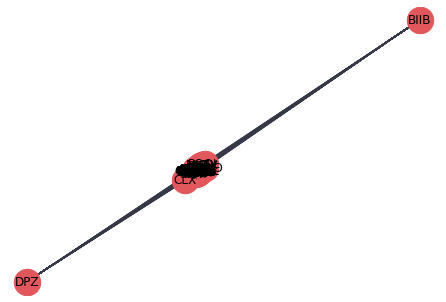

In [10]:
nx.draw(Gt1, with_labels=True, node_size=700, node_color="#e1575c",
        edge_color='#363847',  pos=nx.spectral_layout(Gt1))

In [11]:
# spectral layout takes time to compute (~5secs)
# G0 is simple (i.e. binary edge weights)
# spec layout non determinsitic?
# Gt1 highly clustered on just one stock
# or maybe algo just broke cuz neg weights

In [12]:
Gt1_mst = nx.minimum_spanning_tree(Gt1)
print(nx.info(Gt1_mst))

# check that the MST is weighted:
#Gt1_mst.edges('AAPL')
Gt1_mst.adj['AAPL']

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 503
Average degree:   1.9960


AtlasView({'UA': {'weight': -0.11753118021868804}})

Centrality/peripherality measures: 
* degree 
* betweenness-centrality
* eccentricity
* closeness
* eigenvector-centrality

In [13]:
print('Testing runtime for graph operations:\n')

print('\nMST construction from correlation')
%timeit nx.minimum_spanning_tree(Gt1)
print('\nDegree')
%timeit nx.degree(Gt1_mst)
print('\nBetweenness Centrality')
%timeit nx.betweenness_centrality(Gt1_mst)
print('\nEccentricity')
%timeit nx.eccentricity(Gt1_mst)
print('\nCloseness')
%timeit nx.closeness_centrality(Gt1_mst)
print('\nEigenvector Centrality')
%timeit nx.eigenvector_centrality(Gt1_mst)

Testing runtime for graph operations:


MST construction from correlation
335 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Degree
1.03 µs ± 24 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

Betweenness Centrality
700 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Eccentricity
248 ms ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Closeness
233 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Eigenvector Centrality
54.7 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
# need to preprocess the corr mat before MST-ing them (ad-hoc mapping to euclidean/similarity measures)
# notably, measures require different corr-preprocessing before casting it into a simple graph by MST/PMFG
# (so their resultant graphs are not necessarily the same)

# unweighted degree
#deg= pd.DataFrame.from_dict(dict(Gt1_mst.degree), orient='index', columns = ['D'])
# weighted degree, a.k.a. strength
deg= pd.DataFrame.from_dict(dict(Gt1_mst.degree(weight='weight')), orient='index', columns = ['D'])
BC = pd.DataFrame.from_dict(nx.betweenness_centrality(Gt1_mst), orient='index', columns = ['BC'])
ecc= pd.DataFrame.from_dict(nx.eccentricity(Gt1_mst), orient='index', columns = ['E'])
clo= pd.DataFrame.from_dict(nx.closeness_centrality(Gt1_mst), orient='index', columns = ['C'])
EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(Gt1_mst), orient='index', columns = ['EC'])

In [15]:
# use DIFFERENT edge weights for different centrality measures, as per Pozzi

#D and EC
temp_weights = correlation_matrix+1
G_temp = nx.from_pandas_adjacency(temp_weights-np.diag(np.diag(temp_weights)))
G_temp = nx.minimum_spanning_tree(G_temp)
deg= pd.DataFrame.from_dict(dict(G_temp.degree(weight='weight')), orient='index', columns = ['D'])
EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G_temp), orient='index', columns = ['EC'])

# BC, E, C
temp_weights = np.sqrt(2*(1-correlation_matrix))
G_temp = nx.from_pandas_adjacency(temp_weights)
G_temp = nx.minimum_spanning_tree(G_temp)
ecc= pd.DataFrame.from_dict(nx.eccentricity(G_temp), orient='index', columns = ['E'])
clo= pd.DataFrame.from_dict(nx.closeness_centrality(G_temp), orient='index', columns = ['C'])
BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G_temp), orient='index', columns = ['BC'])

In [16]:
#centralities_names = ['BC', 'C', 'D', 'E', 'EC']
centralities_names = ['D', 'BC', 'E', 'C', 'EC']

centralities = deg
centralities['BC'] = BC
centralities['E']  = ecc
centralities['C']  = clo
centralities['EC'] = EC
print(centralities.head())

              D        BC   E         C        EC
AAPL   0.882469  0.000000  32  0.056504  0.000056
MSFT   0.882933  0.019770  31  0.059909  0.000056
AMZN   0.728996  0.011905  31  0.059881  0.000087
FB     0.840283  0.003976  31  0.059852  0.000086
GOOGL  0.995202  0.003976  32  0.056542  0.000042


In [17]:
centralities.corr()

,D,BC,E,C,EC
D,1.000000,-0.021879,0.044409,-0.074627,0.601503
BC,-0.021879,1.000000,-0.311766,0.442624,0.094830
E,0.044409,-0.311766,1.000000,-0.836337,-0.286736
C,-0.074627,0.442624,-0.836337,1.000000,0.226395
EC,0.601503,0.094830,-0.286736,0.226395,1.000000


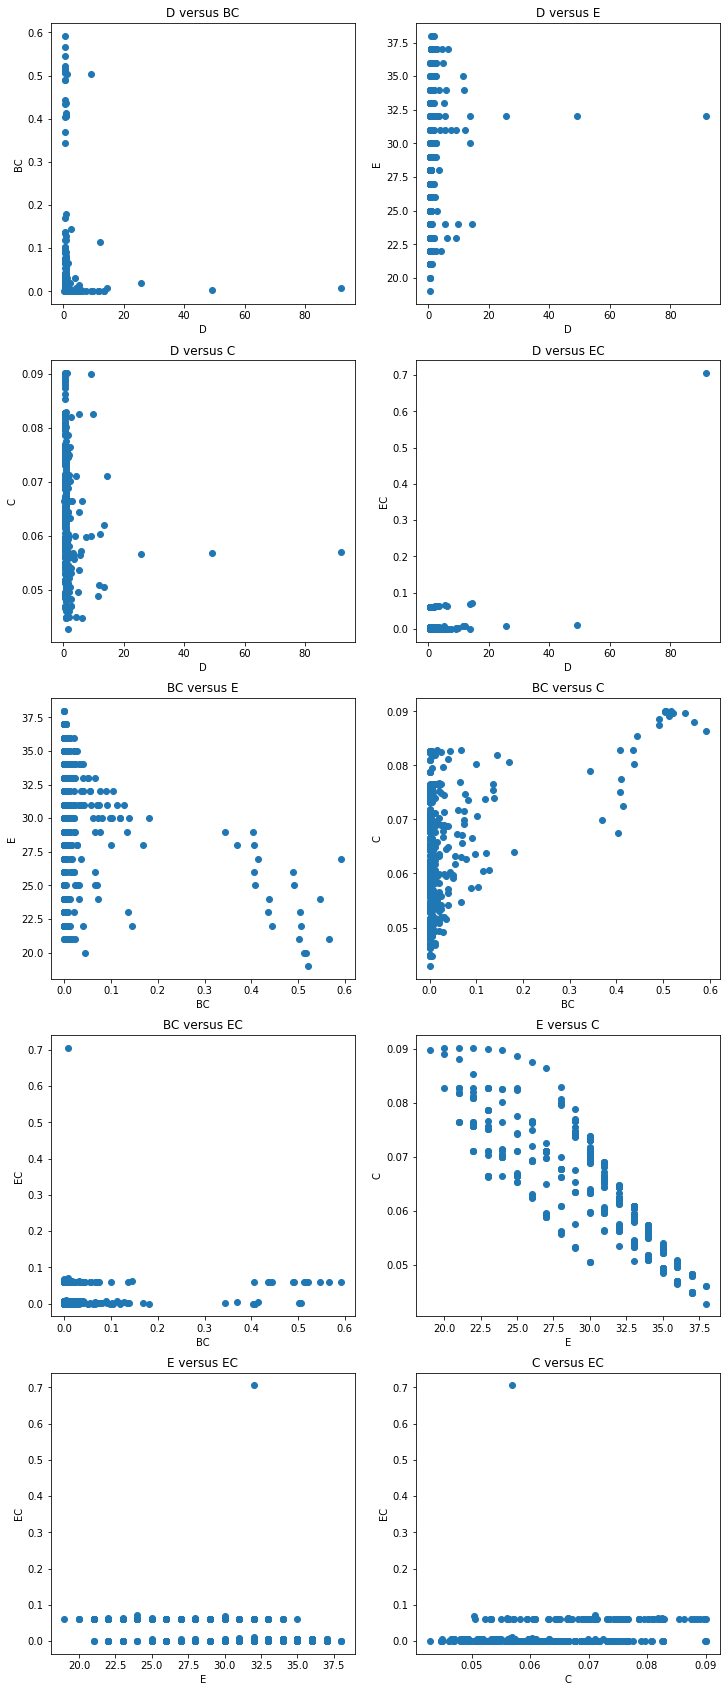

In [18]:
from itertools import combinations

plot_len = 6
plt.figure(figsize=(plot_len*2, plot_len*5))

i=1
for x,y in combinations(centralities_names, 2):
    plt.subplot(5, 2, i)      #5C2 = 10
    plt.scatter(centralities[x], centralities[y])
    plt.title(x+' versus '+y)
    plt.xlabel(x)
    plt.ylabel(y)
    i+=1

In [19]:
for cen_measure in centralities_names:
    print(cen_measure + ': ' + centralities[cen_measure].idxmax())

D: CLX
BC: AFL
E: LLY
C: HBAN
EC: CLX


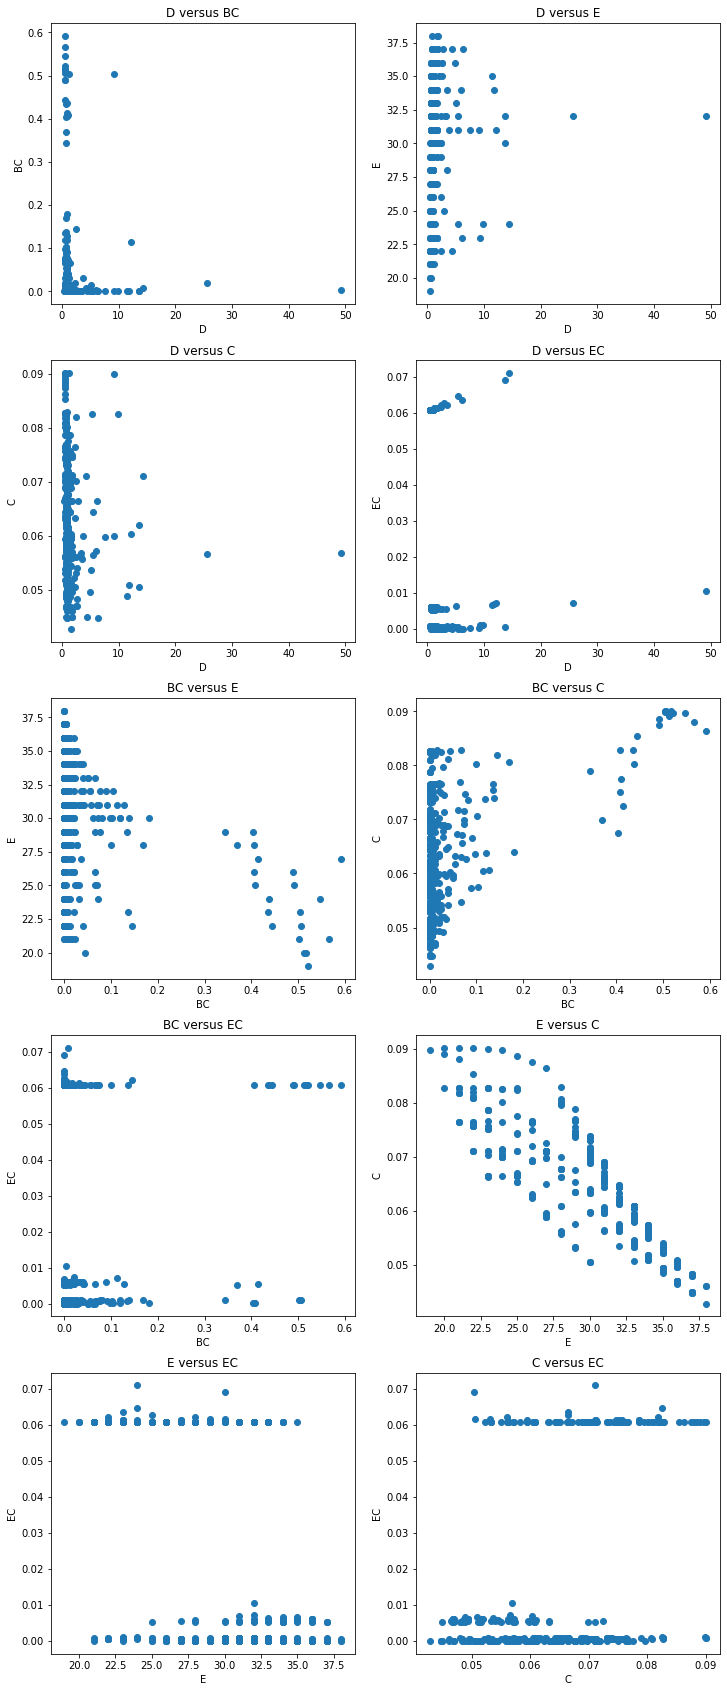

In [20]:
# plot, but remove the outlier (i.e. root node)
plot_len = 6
plt.figure(figsize=(plot_len*2, plot_len*5))

cen_noout = centralities.drop(['CLX'])
i=1
for x,y in combinations(centralities_names, 2):
    plt.subplot(5, 2, i)
    plt.scatter(cen_noout[x], cen_noout[y])
    plt.title(x+' versus '+y)
    plt.xlabel(x)
    plt.ylabel(y)
    i+=1

##### Draw better trees
https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx

## Use D/BC/E/C/EC as features
Attempted to use these node properties as features and visualize them. Excluded the outlier ($CLX) a.k.a. the root-node of the min-spanning tree.

Using some embedding methods to visualize these features:

In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

# preprocess the data to have zero mean and unit var.
# (or do i have to normalize by L2/L1?)
cen = scale(cen_noout)      # excludes the root-node ($CLX)
pca = PCA(n_components=2)
pca.fit(cen)

print('Explained variance by first two PCs:')
print(pca.explained_variance_ratio_)
print('First two PCs:')
print(centralities_names)
print(pca.components_)

Explained variance by first two PCs:
[0.4745591  0.19887582]
First two PCs:
['D', 'BC', 'E', 'C', 'EC']
[[-0.07411071  0.37129042 -0.58427039  0.59257179  0.40513925]
 [ 0.99521541  0.07135754 -0.04313739  0.00244555  0.05086817]]


In [66]:
for cname, pc1, pc2 in zip(centralities_names, pca.components_[0],  pca.components_[1]):
    print(cname, ': %.3f | %.3f' %(pc1, pc2))

D : -0.074 | 0.995
BC : 0.371 | 0.071
E : -0.584 | -0.043
C : 0.593 | 0.002
EC : 0.405 | 0.051


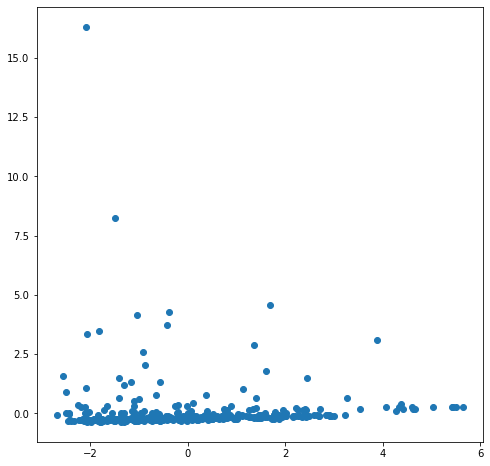

In [67]:
DR = pca.transform(cen)
plt.figure(figsize=(8,8))
plt.scatter(DR[:,0], DR[:,1]);

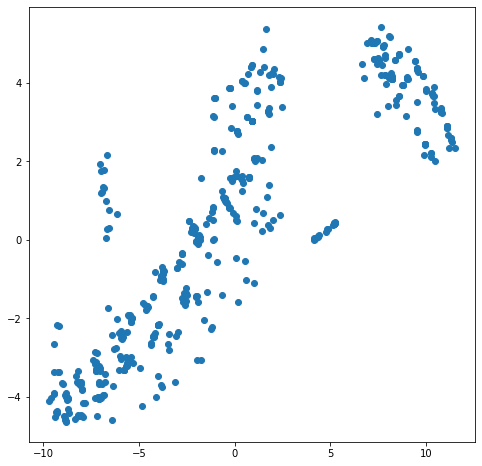

In [70]:
perp = 120
n_iter = 1000           # default = 1000
tsne = TSNE(n_components=2, perplexity=perp, n_iter=n_iter)
DR = tsne.fit_transform(cen)

plt.figure(figsize=(8,8))
plt.scatter(DR[:,0], DR[:,1]);